In [ ]:
!nvidia-smi


Wed Jul 10 11:59:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

# Set the paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/shimu defense/mymodeldetails/model.h5'
MODEL_HISTORY_CSV_PATH = '/content/drive/MyDrive/shimu defense/mymodeldetails/model_history.csv'
train_dir = '/content/drive/MyDrive/shimu defense/brone fracture train test val/train'
validation_dir = '/content/drive/MyDrive/shimu defense/brone fracture train test val/val'
test_dir = '/content/drive/MyDrive/shimu defense/brone fracture train test val/test'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Define the custom CNN model using Functional API with residual connections
def residual_block(x, filters, kernel_size=3, stride=1):
    res = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.01))(x)
    res = BatchNormalization()(res)
    res = tf.keras.activations.relu(res)
    res = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.01))(res)
    res = BatchNormalization()(res)

    if x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)

    x = Add()([x, res])
    x = tf.keras.activations.relu(x)
    return x

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 256)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = build_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(MODEL_HISTORY_CSV_PATH)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, early_stopping, reduce_lr]
)

# Save the overall CSV file
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_CSV_PATH, index=False)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



# Save the model
model.save(MODEL_SAVE_PATH)


Found 6654 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 1893 images belonging to 2 classes.
Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 15.5568 - accuracy: 0.5396 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 3398s 16s/step - loss: 15.5568 - accuracy: 0.5396 - val_loss: 11.9373 - val_accuracy: 0.5151 - lr: 1.0000e-04
Epoch 2/50
207/207 [==============================] - 124s 597ms/step - loss: 9.5181 - accuracy: 0.5776 - val_loss: 7.6312 - val_accuracy: 0.4903 - lr: 1.0000e-04
Epoch 3/50
207/207 [==============================] - 124s 599ms/step - loss: 6.2224 - accuracy: 0.6342 - val_loss: 5.1854 - val_accuracy: 0.5647 - lr: 1.0000e-04
Epoch 4/50
207/207 [==============================] - 123s 594ms/step - loss: 4.3849 - accuracy: 0.6684 - val_loss: 4.0155 - val_accuracy: 0.5248 - lr: 1.0000e-04
Epoch 5/50
207/207 [==============================] - 129s 622ms/step - loss: 3.2840 - accuracy: 0.6945 - val_loss: 2.8412 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 6/50
207/207 [==============================] - 125s 605ms/step - loss: 2.5828 - accuracy: 0.7067 - val_loss: 3.7763 - val_accuracy: 0.5097 - lr: 1.0000e-04
Epoch 7/50
207/207 [============

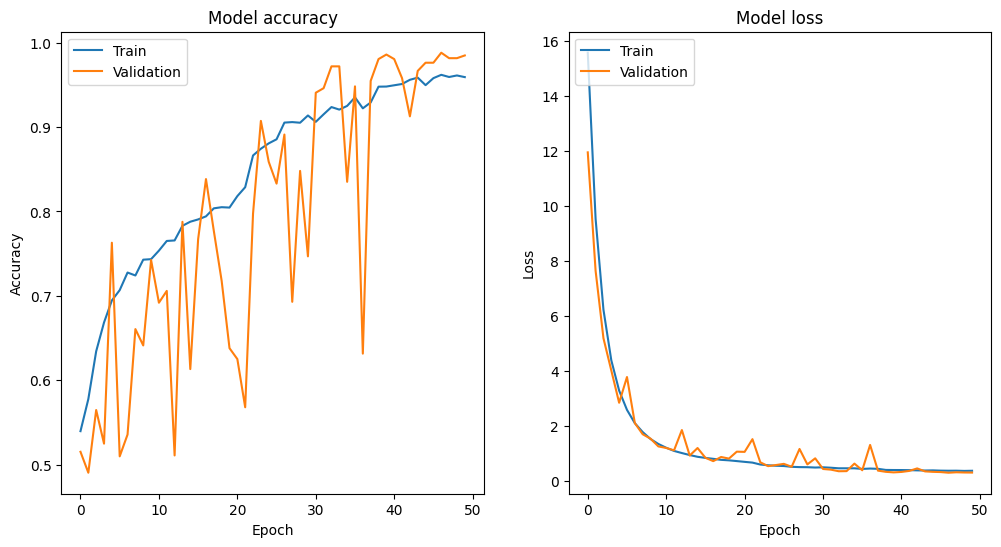

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
history_df = pd.read_csv('/content/drive/MyDrive/shimu defense/mymodeldetails/model_history.csv')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


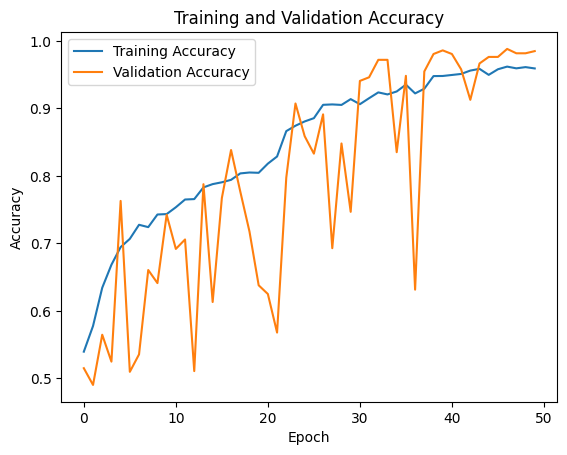

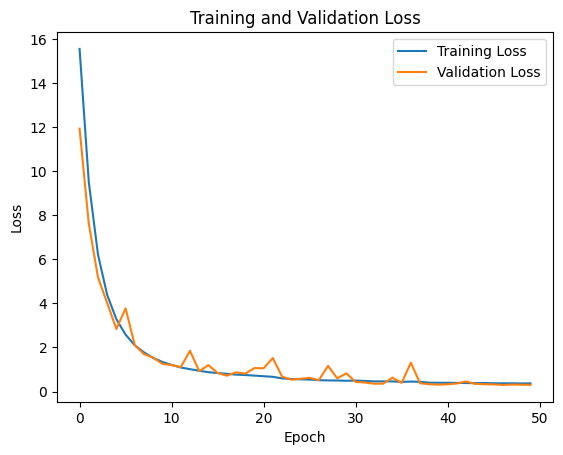

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the history CSV file
history_df = pd.read_csv(MODEL_HISTORY_CSV_PATH)

# Plot training and validation accuracy
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 17s 272ms/step
Precision: 0.9662090813093981
Recall: 0.9891891891891892
F1-score: 0.9775641025641025
Accuracy: 0.9778129952456418
              precision    recall  f1-score   support

    fracture       0.99      0.97      0.98       968
non fracture       0.97      0.99      0.98       925

    accuracy                           0.98      1893
   macro avg       0.98      0.98      0.98      1893
weighted avg       0.98      0.98      0.98      1893



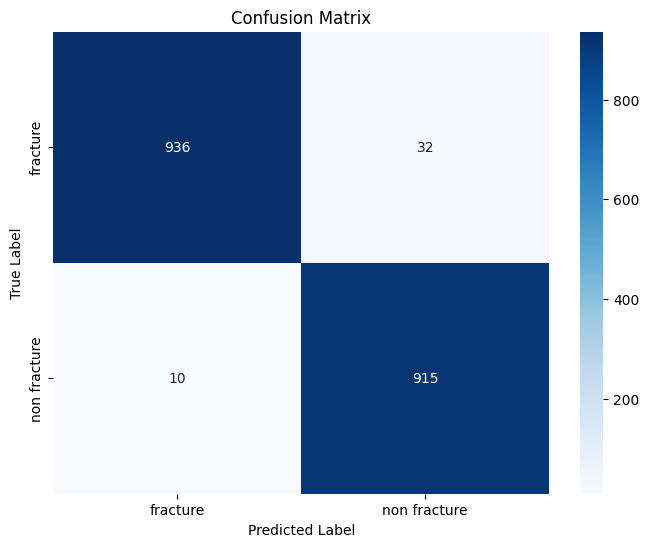

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

# Predict on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Ensure the number of predictions matches the number of true labels
assert len(predicted_classes) == len(true_classes)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
accuracy = accuracy_score(true_classes, predicted_classes)

# Display the scores
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 10s 163ms/step
Precision: 0.9662090813093981
Recall: 0.9891891891891892
F1-score: 0.9775641025641025
Accuracy: 0.9778129952456418
              precision    recall  f1-score   support

    fracture       0.99      0.97      0.98       968
non fracture       0.97      0.99      0.98       925

    accuracy                           0.98      1893
   macro avg       0.98      0.98      0.98      1893
weighted avg       0.98      0.98      0.98      1893



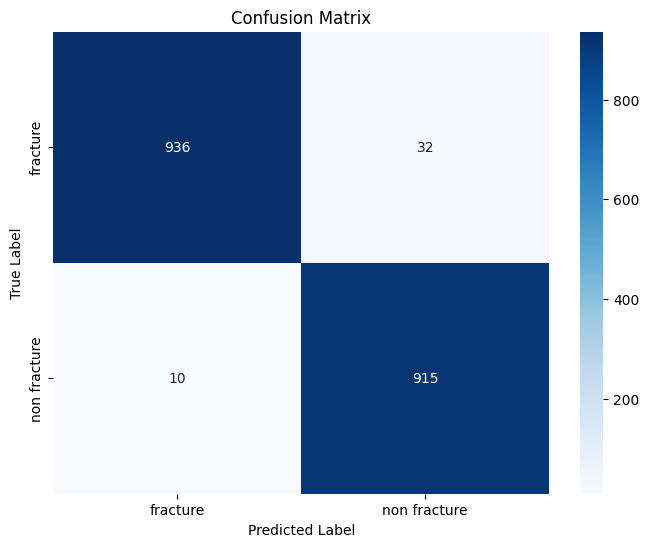

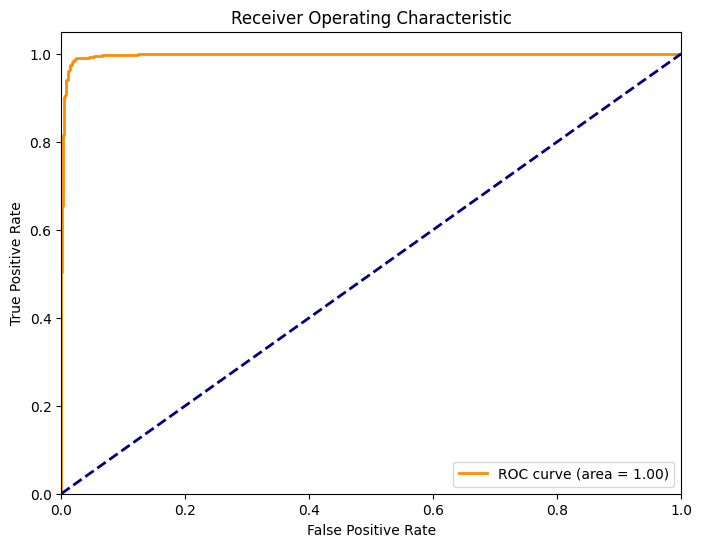

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

# Predict on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Ensure the number of predictions matches the number of true labels
assert len(predicted_classes) == len(true_classes)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
accuracy = accuracy_score(true_classes, predicted_classes)

# Display the scores
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Found 1893 images belonging to 2 classes.
60/60 [==============================] - 10s 163ms/step
AUC: 0.9969


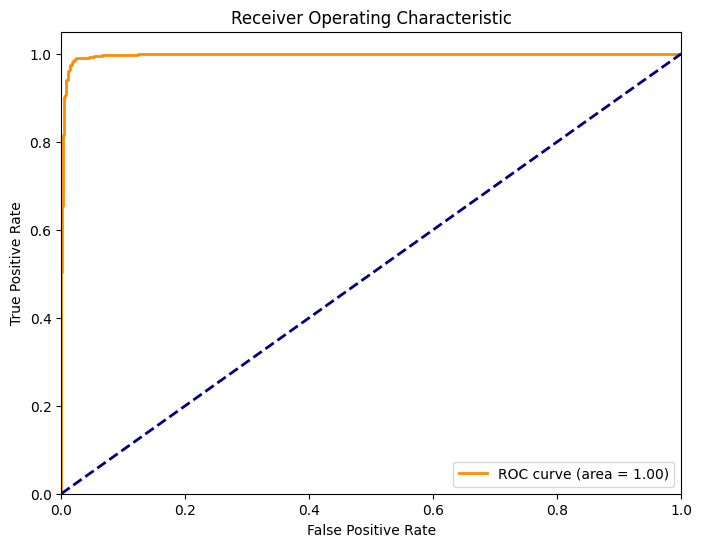

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

# Predict on the test data
predictions = model.predict(test_generator, steps=len(test_generator))

# Get true labels
true_classes = test_generator.classes

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Print AUC value
print(f'AUC: {roc_auc:.4f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
